In [1]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.4     crayon_1.5.2    digest_0.6.31   utf8_1.2.2     
 [5] IRdisplay_1.1   repr_1.1.5      lifecycle_1.0.3 jsonlite_1.8.4 
 [9] evaluate_0.20   pillar_1.8.1    rlang_1.0.6     cli_3.6.0      
[13] uuid_1.1-0      vctrs_0.5.2     IRkernel_1.3.2  tools_4.2.2    
[17] glue_1.6.2      fastmap_1.1.0   compiler_4.2.2  base64enc_0.1-3
[21] pbdZMQ_0.3-9    htmltools_0.5.4

### Required R packages

In [2]:
library(Matrix)
library(Rlinsolve)  # iterative linear solvers
library(SparseM) # for visualization
library(lobstr)
library(microbenchmark)

** ------------------------------------------------------- **

** Rlinsolve

**  - Solving (Sparse) System of Linear Equations

**

** Version    : 0.3.2      (2023)

** Maintainer : Kisung You (kisungyou@outlook.com)

**

** Please share any bugs or suggestions to the maintainer.

** ------------------------------------------------------- **


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




# Iterative Methods for Solving Linear Equations

## Introduction

So far we have considered direct methods for solving linear equations.    

* **Direct methods** (flops fixed _a priori_) vs **iterative methods**:
    - Direct method (GE/LU, Cholesky, QR, SVD): accurate. good for dense, small to moderate sized $\mathbf{A}$  
    - Iterative methods (Jacobi, Gauss-Seidal, SOR, conjugate-gradient, GMRES): accuracy depends on number of iterations. good for large, sparse, structured linear system, parallel computing, warm start (reasonable accuracy after, say, 100 iterations)

## Motivation: PageRank 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/PageRanks-Example.svg/400px-PageRanks-Example.svg.png" width="400" align="center"/>

Source: [Wikepedia](https://en.wikipedia.org/wiki/PageRank)

* $\mathbf{A}  \in \{0,1\}^{n \times n}$ the connectivity matrix of webpages with entries
$$
\begin{eqnarray*}
	a_{ij} = \begin{cases}
	1 &  \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}. 
\end{eqnarray*}
$$
$n \approx 10^9$ in May 2017.

* $r_i = \sum_j a_{ij}$ is the *out-degree* of page $i$. 

* [Larry Page](https://en.wikipedia.org/wiki/PageRank) imagined a random surfer wandering on internet according to following rules:
    - From a page $i$ with $r_i>0$
        * with probability $p$, (s)he randomly chooses a link $j$ from page $i$ (uniformly) and follows that link to the next page  
        * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page 
    - From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page
    
* The process defines an $n$-state Markov chain, where each state corresponds to each page. 
$$
    p_{ij} = (1-p)\frac{1}{n} + p\frac{a_{ij}}{r_i}
$$
with interpretation $a_{ij}/r_i = 1/n$ if $r_i = 0$.

* Stationary distribution of this Markov chain gives the score (long term probability of visit) of each page.

* Stationary distribution can be obtained as the top *left* eigenvector of the transition matrix $\mathbf{P}=(p_{ij})$ corresponding to eigenvalue 1. 
$$
    \mathbf{x}^T\mathbf{P} = \mathbf{x}^T.
$$
Equivalently it can be cast as a linear equation.
$$
    (\mathbf{I} - \mathbf{P}^T) \mathbf{x} = \mathbf{0}.
$$

* You've got to solve a linear equation with $10^9$ variables!

* GE/LU will take $2 \times (10^9)^3/3/10^{12} \approx 6.66 \times 10^{14}$ seconds $\approx 20$ million years on a tera-flop supercomputer!

* Iterative methods come to the rescue.

## Splitting and fixed point iteration

* The key idea of iterative method for solving $\mathbf{A}\mathbf{x}=\mathbf{b}$ is to **split** the matrix $\mathbf{A}$ so that
$$
    \mathbf{A} = \mathbf{M} - \mathbf{K}
$$
where $\mathbf{M}$ is invertible and easy to invert.

* Then $\mathbf{A}\mathbf{x} = \mathbf{M}\mathbf{x} - \mathbf{K}\mathbf{x} = \mathbf{b}$ or
$$
    \mathbf{x} = \mathbf{M}^{-1}\mathbf{K}\mathbf{x} + \mathbf{M}^{-1}\mathbf{b}
    .
$$
Thus a solution to $\mathbf{A}\mathbf{x}=\mathbf{b}$ is a fixed point of iteration
$$
    \mathbf{x}^{(t+1)} = \mathbf{M}^{-1}\mathbf{K}\mathbf{x}^{(t)} + \mathbf{M}^{-1}\mathbf{b}
    = \mathbf{R}\mathbf{x}^{(t)} + \mathbf{c}
    .
$$

* Under a suitable choice of $\mathbf{R}$, i.e., splitting of $\mathbf{A}$, the sequence $\mathbf{x}^{(k)}$ generated by the above iteration converges to a solution $\mathbf{A}\mathbf{x}=\mathbf{b}$:


> Let $\rho(\mathbf{R})=\max_{i=1,\dotsc,n}|\lambda_i(\mathbf{R})|$, where $\lambda_i(\mathbf{R})$ is the $i$th (complex) eigenvalue of $\mathbf{R}$. When $\mathbf{A}$ is invertible, the iteration $\mathbf{x}^{(t+1)}=\mathbf{R}\mathbf{x}^{(t)} + \mathbf{c}$ converges to $\mathbf{A}^{-1}\mathbf{b}$ for any $\mathbf{x}^{(0)}$ if and only if  $\rho(\mathbf{R}) < 1$.

### Review of vector norms

A norm $\|\cdot\|: \mathbb{R}^n \to \mathbb{R}$ is defined by the following properties:

1. $\|\mathbf{x}\| \ge 0$,
2. $\|\mathbf{x}\| = 0 \iff \mathbf{x} = \mathbf{0}$,
3. $\|c\mathbf{x}\| = |c|\|\mathbf{x}\|$ for all $c \in \mathbb{R}$,
4. $\|\mathbf{x} + \mathbf{y}\| \le \|\mathbf{x}\| + \|\mathbf{y}\|$.

Typicall norms are
* $\ell_2$ (Euclidean) norm: $\|\mathbf{x}\| = \sqrt{\sum_{i=1}^nx_i^2}$;
* $\ell_1$ norm: $\|\mathbf{x}\| = \sum_{i=1}^n|x_i|$;
* $\ell_{\infty}$ (Manhatan) norm: $\|\mathbf{x}\| = \max_{i=1,\dots,n}|x_i|$;

### Matrix norms

* Matrix $\mathbf{A} \in \mathbb{R}^{n\times n}$ can be considered as a vector in $\mathbb{R}^{n^2}$. 
* However, it is convinient if a matrix norm is compatible with matrix multiplication.
* In addition to the defining properties of a norm above, we require

5. $\|\mathbf{A}\mathbf{B}\| \le \|\mathbf{A}\|\|\mathbf{B}\|$.

Typical matrix norms are
* Frobenius norm: $\|\mathbf{A}\|_F = \sqrt{\sum_{i,j=1}^n a_{ij}^2} = \sqrt{\text{trace}(\mathbf{A}\mathbf{A}^T)}$;
* Operator norm (induced by a vector norm $\|\cdot\|$): $\|\mathbf{A}\| = \sup_{\mathbf{y}\neq\mathbf{0}}\frac{\|\mathbf{A}\mathbf{y}\|}{\|\mathbf{y}\|}$.

It can be shown that
* $\|\mathbf{A}\|_1 = \max_{j=1,\dotsc,n}\sum_{i=1}^n|a_{ij}|$;
* $\|\mathbf{A}\|_{\infty} = \max_{i=1,\dotsc,n}\sum_{j=1}^n|a_{ij}|$;
* $\|\mathbf{A}\|_2 = \sqrt{\rho(\mathbf{A}^T\mathbf{A})}$.

### Convergence of iterative methods

- Let $\mathbf{x}^{\star}$ be a solution of $\mathbf{A}\mathbf{x} = \mathbf{b}$.
- Equivalently, $\mathbf{x}^{\star}$ satisfies $\mathbf{x}^{\star} = \mathbf{R}\mathbf{x}^{\star} + \mathbf{c}$.
- Subtracting this from $\mathbf{x}^{(t+1)} = \mathbf{R}\mathbf{x}^{(t)} + \mathbf{c}$, we have
$$
    \mathbf{x}^{(t+1)} - \mathbf{x}^{\star} = \mathbf{R}(\mathbf{x}^{(t)} - \mathbf{x}^{\star}).
$$
- Take a vector norm on both sides:
$$
    \|\mathbf{x}^{(t+1)} - \mathbf{x}^{\star}\| = \|\mathbf{R}(\mathbf{x}^{(t)} - \mathbf{x}^{\star})\| 
    \le \|\mathbf{R}\|\|\mathbf{x}^{(t)} - \mathbf{x}^{\star}\|
$$
where $\|\mathbf{R}\|$ is the induced operator norm.
- Thus if $\|\mathbf{R}\| < 1$ for a certain (induced) norm, then $\mathbf{x}^{(t)} \to \mathbf{x}^{\star}$.

### Theorem

> The spectral radius $\rho(\mathbf{A})$ of a matrix $\mathbf{A}\in\mathbb{R}^{n\times n}$ satisfies
$$
    \rho(\mathbf{A}) \le \|\mathbf{A}\|
$$
for any operator norm. Furthermore, for any $\mathbf{A}\in\mathbb{R}^{n\times n}$  and $\epsilon > 0$, there is an operator norm $\|\cdot\|$ such that $\|\mathbf{A}\| \le \rho(\mathbf{A}) + \epsilon$.
\
In other words,
$$
    \rho(\mathbf{A}) = \inf_{\|\cdot\|: \text{operator norm}} \|\mathbf{A}\|.
$$

> Thus it is immediate to see
$$
    \rho(\mathbf{A}) < 1 \iff \|\mathbf{A}\| < 1
$$
for some operator norm.

#### Proof
If $\lambda$ is an eigenvalue of $\mathbf{A}$ with nonzero eigenvector $\mathbf{v}$, then
$$
    \|\mathbf{A}\mathbf{v}\| = |\lambda|\|\mathbf{v}\|
$$
(for a vector norm). So 
$$
    |\lambda| = \frac{\|\mathbf{A}\mathbf{v}\|}{\|\mathbf{v}\|} \le \|\mathbf{A}\|,
$$
implying the first inequality.

For the second part, suppose $\mathbf{A}\in\mathbb{R}^{n\times n}$  and $\epsilon > 0$ are given. Then there exists an (complex) upper triangular matrix $\mathbf{T}$ and an invertible matrix $\mathbf{S}$ such that
$$
    \mathbf{A} = \mathbf{S}\mathbf{T}\mathbf{S}^{-1}
$$
and the eigenvalues of $\mathbf{A}$ coincides with the diagonal entries of $\mathbf{T}$.
(Schur decomposition).

For $\delta > 0$ consider a diagonal matrix $\mathbf{D}(\delta)=\text{diag}(1, \delta, \delta^2, \dotsc, \delta^{n-1})$, which is invertible. Then 

$$
\mathbf{T}(\delta) 
\triangleq \mathbf{D}(\delta)^{-1}\mathbf{T}\mathbf{D}(\delta)
=\mathbf{D}(\delta)^{-1}\mathbf{S}^{-1}\mathbf{A}\mathbf{S}\mathbf{D}(\delta) 
= (\mathbf{S}\mathbf{D}(\delta))^{-1}\mathbf{A}(\mathbf{S}\mathbf{D}(\delta))
$$

is an upper triangular matrix with entries $(\delta^{j-i}t_{ij})$ for $j \ge i$. So the off-diagonal entries tends to 0 as $\delta \to 0$.

Check
$$
\|\mathbf{x}\|_{\delta} := \|(\mathbf{S}\mathbf{D}(\delta))^{-1}\mathbf{x}\|_{\infty}
$$
defines a vector norm, which induces

$$
\begin{split}
\|\mathbf{A}\|_{\delta} 
&\triangleq \sup_{\mathbf{x}\neq\mathbf{0}}\frac{\|\mathbf{A}\mathbf{x}\|_{\delta}}{\|\mathbf{x}\|_{\delta}}
= \sup_{\mathbf{x}\neq\mathbf{0}}\frac{\|[\mathbf{S}\mathbf{D}(\delta)]^{-1}\mathbf{A}\mathbf{x}\|_{\infty}}{\|[\mathbf{S}\mathbf{D}(\delta)]^{-1}\mathbf{x}\|_{\infty}}
\\
&= \|(\mathbf{S}\mathbf{D}(\delta))^{-1}\mathbf{A}(\mathbf{S}\mathbf{D}(\delta))\|_{\infty} = \|\mathbf{T}(\delta)\|_{\infty}
= \max_{i=1,\dotsc,n}\sum_{j=i}^n |t_{ij}|\delta^{j-i}.
\end{split}
$$

Since for
$\mathbf{y} = [\mathbf{S}\mathbf{D}(\delta)]^{-1}\mathbf{x}$, there holds $\mathbf{x} = [\mathbf{S}\mathbf{D}(\delta)]\mathbf{y}$ and
\
$$
\sup_{\mathbf{x}\neq\mathbf{0}}\frac{\|[\mathbf{S}\mathbf{D}(\delta)]^{-1}\mathbf{A}\mathbf{x}\|_{\infty}}{\|[\mathbf{S}\mathbf{D}(\delta)]^{-1}\mathbf{x}\|_{\infty}}
= 
\sup_{\mathbf{y}\neq\mathbf{0}}\frac{\|[\mathbf{S}\mathbf{D}(\delta)]^{-1}\mathbf{A}[\mathbf{S}\mathbf{D}(\delta)]\mathbf{y}\|_{\infty}}{\|[\mathbf{S}\mathbf{D}(\delta)]^{-1}[\mathbf{S}\mathbf{D}(\delta)]\mathbf{y}\|_{\infty}}
=
\sup_{\mathbf{y}\neq\mathbf{0}}\frac{\|[\mathbf{S}\mathbf{D}(\delta)]^{-1}\mathbf{A}[\mathbf{S}\mathbf{D}(\delta)]\mathbf{y}\|_{\infty}}{\|\mathbf{y}\|_{\infty}}
$$

Now since the eigenvalues of $\mathbf{A}$ coincides with $t_{ii}$, for each $\epsilon>0$ we can take a sufficiently small $\delta > 0$ so that
$$
    \max_{i=1,\dotsc,n}\sum_{j=i}^n |t_{ij}|\delta^{j-i} \le \rho(\mathbf{A}) + \epsilon.
$$
This implies $\|\mathbf{A}\|_{\delta} \le \rho(\mathbf{A}) + \epsilon$. 

### Implications

* Recall
> Let $\rho(\mathbf{R})=\max_{i=1,\dotsc,n}|\lambda_i(\mathbf{R})|$, where $\lambda_i(\mathbf{R})$ is the $i$th (complex) eigenvalue of $\mathbf{R}$. When $\mathbf{A}$ is invertible, the iteration $\mathbf{x}^{(t+1)}=\mathbf{R}\mathbf{x}^{(t)} + \mathbf{c}$ converges to $\mathbf{A}^{-1}\mathbf{b}$ for any $\mathbf{x}^{(0)}$ if and only if  $\rho(\mathbf{R}) < 1$.

* The *if* part is proved using the above Theorem. This part holds even if $\mathbf{A}$ is singular; the limit may depend on $\mathbf{x}^{(0)}$, but it is always a solution to $\mathbf{A}\mathbf{x} = \mathbf{b}$.

* The *only if* part when $\mathbf{A}$ is inverible (hence $\mathbf{x}^{\star}$ is unique):
\
$$
    \mathbf{x}^{(t)} - \mathbf{x}^{\star} = \mathbf{R}^t(\mathbf{x}^{(0)} - \mathbf{x}^{\star}).
$$
\
If LHS converges to zero for any $\mathbf{x}^{(0)}$, then $\mathbf{R}^t \to \mathbf{0}$ as $t \to \infty$. This cannot occur if $|\lambda_i(\mathbf{R})| \ge 1$ for some $i$: if $\mathbf{x}^{(0)} = \mathbf{v}_i + \mathbf{x}^{\star}$ for an eigenvector $\mathbf{v}_i \neq \mathbf{0}$ such that $\mathbf{R}\mathbf{v}_i = \lambda_i\mathbf{v}_i$, then $\| R^t(\mathbf{x}^{(0)} - \mathbf{x}^{\star}) \| = |\lambda_i|^t\|\mathbf{v}_i\| \geq \|\mathbf{v}_i\| \neq 0$.
    + Invertibility is necessary since otherwise we do not know if $\mathbf{x}^{(t)}$ converges to a unique point.

## Jacobi's method

$$
x_i^{(t+1)} = \frac{b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(t)} - \sum_{j=i+1}^n a_{ij} x_j^{(t)}}{a_{ii}}.
$$


* Split $\mathbf{A} = \mathbf{L} + \mathbf{D} + \mathbf{U}$ = (strictly lower triangular) + (diagonal) + (strictly upper triangular).


* Take $\mathbf{M}=\mathbf{D}$ (easy to invert!) and $\mathbf{K}=-(\mathbf{L} + \mathbf{U})$:
$$
    \mathbf{D} \mathbf{x}^{(t+1)} = - (\mathbf{L} + \mathbf{U}) \mathbf{x}^{(t)} + \mathbf{b},
$$
i.e., 
$$
	\mathbf{x}^{(t+1)} = - \mathbf{D}^{-1} (\mathbf{L} + \mathbf{U}) \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b} = - \mathbf{D}^{-1} \mathbf{A} \mathbf{x}^{(t)} + \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b}.
$$

* Convergence is guaranteed if $\mathbf{A}$ is striclty row diagonally dominant: $|a_{ii}| > \sum_{j\neq i}|a_{ij}|$.

* One round costs $2n^2$ flops with an **unstructured** $\mathbf{A}$. Gain over GE/LU if converges in $o(n)$ iterations. 

* Saving is huge for **sparse** or **structured** $\mathbf{A}$. By structured, we mean the matrix-vector multiplication $\mathbf{A} \mathbf{v}$ is fast ($O(n)$ or $O(n \log n)$).
    - Often the multiplication is implicit and $\mathbf{A}$ is not even stored, e.g., finite difference: $(\mathbf{A}\mathbf{v})_i = v_i - v_{i+1}$.

## Gauss-Seidel method

$$
x_i^{(t+1)} = \frac{b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(t+1)} - \sum_{j=i+1}^n a_{ij} x_j^{(t)}}{a_{ii}}.
$$

* Split $\mathbf{A} = \mathbf{L} + \mathbf{D} + \mathbf{U}$ = (strictly lower triangular) + (diagonal) + (strictly upper triangular) as Jacobi.

* Take $\mathbf{M}=\mathbf{D}+\mathbf{L}$ (easy to invert, why?) and $\mathbf{K}=-\mathbf{U}$:
$$
(\mathbf{D} + \mathbf{L}) \mathbf{x}^{(t+1)} = - \mathbf{U} \mathbf{x}^{(t)} + \mathbf{b}
$$
i.e., 
$$
\mathbf{x}^{(t+1)} = - (\mathbf{D} + \mathbf{L})^{-1} \mathbf{U} \mathbf{x}^{(t)} + (\mathbf{D} + \mathbf{L})^{-1} \mathbf{b}.
$$

* Equivalent to
$$
\mathbf{D}\mathbf{x}^{(t+1)} = - \mathbf{L} \mathbf{x}^{(t+1)} - \mathbf{U} \mathbf{x}^{(t)} + \mathbf{b}
$$
or
$$
\mathbf{x}^{(t+1)} = \mathbf{D}^{-1}(- \mathbf{L} \mathbf{x}^{(t+1)} - \mathbf{U} \mathbf{x}^{(t)} + \mathbf{b})
$$
leading to the iteration.

* "Coordinate descent" version of Jacobi.

* Convergence is guaranteed if $\mathbf{A}$ is striclty row diagonally dominant.

## Successive over-relaxation (SOR)

$$
x_i^{(t+1)} = \frac{\omega}{a_{ii}} \left( b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(t+1)} - \sum_{j=i+1}^n a_{ij} x_j^{(t)} \right)+ (1-\omega) x_i^{(t)},
$$

* $\omega=1$: Gauss-Seidel; $\omega \in (0, 1)$: underrelaxation; $\omega > 1$: overrelaxation
    - Relaxation in hope of faster convergence
    
* Split $\mathbf{A} = \mathbf{L} + \mathbf{D} + \mathbf{U}$ = (strictly lower triangular) + (diagonal) + (strictly upper triangular) as before.

* Take $\mathbf{M}=\frac{1}{\omega}\mathbf{D}+\mathbf{L}$ (easy to invert, why?) and $\mathbf{K}=\frac{1-\omega}{\omega}\mathbf{D}-\mathbf{U}$:
$$
\begin{split}
(\mathbf{D} + \omega \mathbf{L})\mathbf{x}^{(t+1)} &= [(1-\omega) \mathbf{D} - \omega \mathbf{U}] \mathbf{x}^{(t)} +  \omega \mathbf{b} 
\\
\mathbf{D}\mathbf{x}^{(t+1)} &= (1-\omega) \mathbf{D}\mathbf{x}^{(t)} + \omega ( -\mathbf{U}\mathbf{x}^{(t)} - \mathbf{L}\mathbf{x}^{(t+1)}  + \mathbf{b} )
\\
\mathbf{x}^{(t+1)} &= (1-\omega)\mathbf{x}^{(t)} + \omega \mathbf{D}^{-1} ( -\mathbf{U}\mathbf{x}^{(t)} - \mathbf{L}\mathbf{x}^{(t+1)}  + \mathbf{b} )
\end{split}
$$

## Conjugate gradient method

* **Conjugate gradient and its variants are the top-notch iterative methods for solving huge, structured linear systems.**

* Key idea: solving $\mathbf{A} \mathbf{x} = \mathbf{b}$ is equivalent to minimizing the quadratic function $\frac{1}{2} \mathbf{x}^T \mathbf{A} \mathbf{x} - \mathbf{b}^T \mathbf{x}$ if $\mathbf{A}$ *is positive definite*.

    [Application to a fusion problem in physics](http://www.sciencedirect.com/science/article/pii/0021999178900980?via%3Dihub):

| Method                                 | Number of Iterations |
|----------------------------------------|----------------------|
| Gauss-Seidel                           | 208,000              |
| Block SOR methods                      | 765                  |
| Incomplete Cholesky conjugate gradient | 25                   |


* We defer the details of CG to the graduate-level Advanced Statistical Computing course.

## Numerical examples

The [`Rlinsolve`](https://cran.r-project.org/web/packages/Rlinsolve/index.html) package implements most commonly used iterative solvers.

### Generate test matrix

Poisson matrix is a block tridiagonal matrix from (discretized) Poisson's equation $\nabla^2\psi = f$ in on the plane (with a certain boundary condition). This matrix is sparse, symmetric positive definite and has known eigenvalues.

Reference:
G. H. Golub and C. F. Van Loan, Matrix Computations, second edition, Johns Hopkins University Press, Baltimore, Maryland, 1989 (Section 4.5.4).

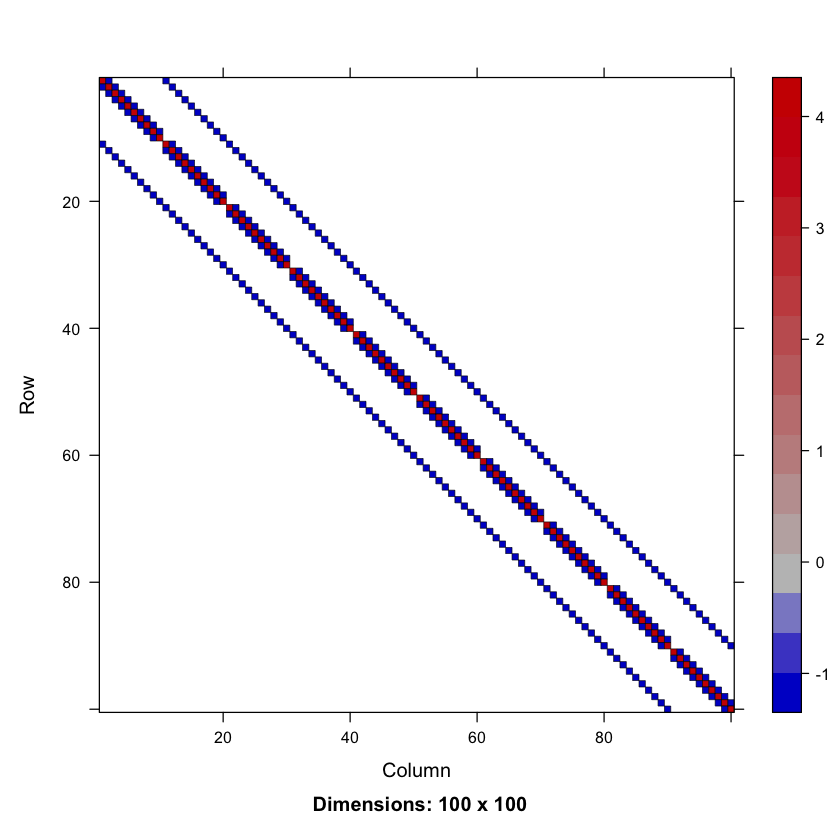

In [3]:
get1DPoissonMatrix <- function(n) {
      Matrix::bandSparse(n, n, #dimensions
                        (-1):1, #band, diagonal is number 0
                        list(rep(-1, n-1), 
                        rep(4, n), 
                        rep(-1, n-1)))
}
get2DPoissonMatrix <- function(n) {  # n^n by n^n
    T <- get1DPoissonMatrix(n)
    eye <- Matrix::Diagonal(n)
    N <- n * n  ## dimension of the final square matrix
    ## construct two block diagonal matrices
    D <- bdiag(rep.int(list(T), n))
    O <- bdiag(rep.int(list(-eye), n - 1))

    ## augment O and add them together with D
    D +
     rbind(cbind(Matrix(0, nrow(O), n), O), Matrix(0, n, N)) + 
     cbind(rbind(Matrix(0, n, ncol(O)), O), Matrix(0, N, n))
}
M <- get2DPoissonMatrix(10)
SparseM::image(M)

In [4]:
n <- 50
# Poisson matrix of dimension n^2=2500 by n^2, pd and sparse
A <- get2DPoissonMatrix(n)  # sparse
# dense matrix representation of A
Afull <- as.matrix(A)
# sparsity level
nnzero(A) / length(A)

[1] 0.001968

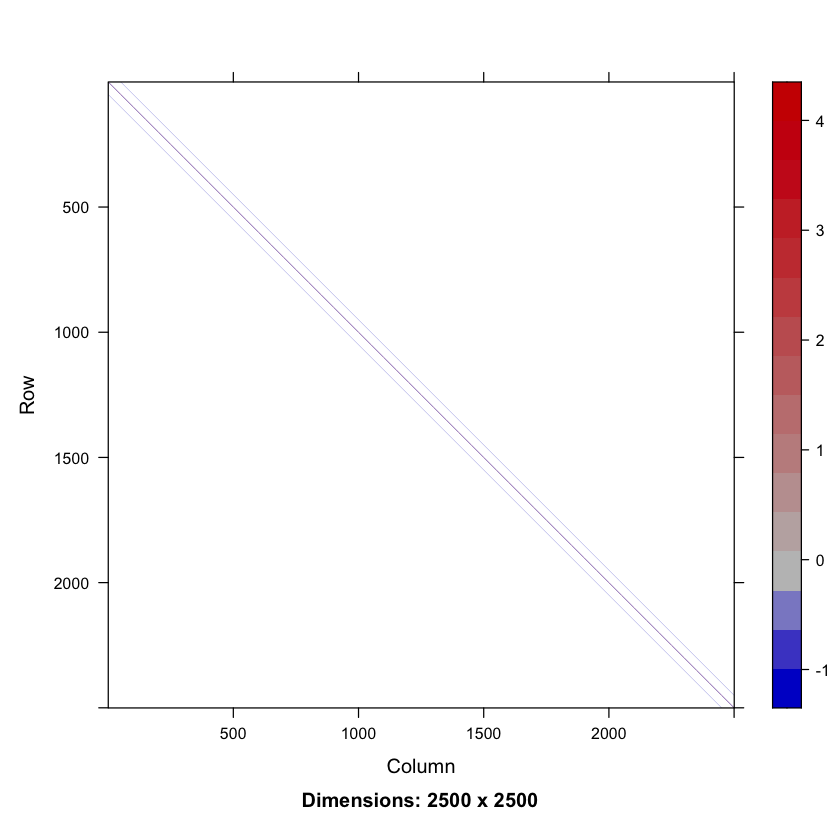

In [5]:
SparseM::image(A)

In [6]:
# storage difference
lobstr::obj_size(A) 
lobstr::obj_size(Afull)

159.10 kB

50.00 MB

### Matrix-vector muliplication

In [7]:
# randomly generated vector of length n^2
set.seed(456) # seed
b <- rnorm(n^2)
# dense matrix-vector multiplication
res <- microbenchmark::microbenchmark(Afull %*% b, A %*% b)
print(res)

Unit: microseconds
        expr      min       lq       mean   median        uq       max neval
 Afull %*% b 7090.305 7221.748 7606.84783 7395.649 7503.4010 29630.831   100
     A %*% b   45.807   62.904   97.95374   87.342  111.3875   799.715   100
 cld
   b
  a 


### Dense solve via Cholesky

In [8]:
# record the Cholesky solution
#Achol <- base::chol(Afull)   # awfully slow
Achol <- Matrix::Cholesky(A)  # sparse Cholesky

In [9]:
# two triangular solves;  2n^2 flops
#y <- solve(t(Achol), b) 
#xchol <- solve(Achol, y)
xchol <- solve(Achol, b)

### Jacobi solver

It seems that Jacobi solver doesn't give the correct answer.

In [10]:
xjacobi <- Rlinsolve::lsolve.jacobi(A, b)
Matrix::norm(xjacobi$x - xchol, 'F') / Matrix::norm(xchol, 'F')

* lsolve.jacobi : Initialiszed.

* lsolve.jacobi : computations finished.



[1] 0.1912401

[Documentation](https://cran.r-project.org/web/packages/Rlinsolve/Rlinsolve.pdf) reveals that the default value of `maxiter` is 1000. A couple trial runs shows that 5000 Jacobi iterations are required to get an "accurate enough" solution.

In [11]:
xjacobi <- Rlinsolve::lsolve.jacobi(A, b, maxiter=5000)
Matrix::norm(xjacobi$x - xchol, 'F') / Matrix::norm(xchol, 'F')

* lsolve.jacobi : Initialiszed.

* lsolve.jacobi : computations finished.



[1] 0.001809093

In [12]:
xjacobi$iter

[1] 4690

### Gauss-Seidel

In [13]:
# Gauss-Seidel solution is fairly close to Cholesky solution after 5000 iters
xgs <- Rlinsolve::lsolve.gs(A, b, maxiter=5000)
Matrix::norm(xgs$x - xchol, 'F') / Matrix::norm(xchol, 'F')

* lsolve.gs : Initialiszed.

* lsolve.gs : computations finished.



[1] 0.001811784

In [14]:
xgs$iter

[1] 1548

### SOR

In [15]:
# symmetric SOR with ω=0.75
xsor <- Rlinsolve::lsolve.ssor(A, b, w=0.75, maxiter=5000)
Matrix::norm(xsor$x - xchol, 'F') / Matrix::norm(xchol, 'F')

* lsolve.ssor : Initialiszed.

* lsolve.ssor : computations finished.



[1] 0.001788622

In [16]:
xsor$iter

[1] 1303

### Conjugate Gradient

In [17]:
# conjugate gradient
xcg <- Rlinsolve::lsolve.cg(A, b)
Matrix::norm(xcg$x - xchol, 'F') / Matrix::norm(xchol, 'F')

* lsolve.cg : Initialiszed.

* lsolve.cg : preprocessing finished ...

* lsolve.cg : convergence was well achieved.

* lsolve.cg : computations finished.



[1] 9.387256e-06

In [18]:
xcg$iter

[1] 119

* A basic tenet in numerical analysis: 

> **The structure should be exploited whenever possible in solving a problem.** 